# Fitting model to Donor 2

Using Donor 2 as example dataset for generating figures in Wasdin et. al.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import Levenshtein as Lev
import statsmodels.discrete.discrete_model as dm
import scipy.optimize
import scipy.stats as st

import os
import warnings
from datetime import datetime

# Load in custom functions
from MM_functions import model_fit_functions as ff

fig_output = './figures/'
# Whether or not to output figures
save = True # False

date = datetime.today().strftime('%Y-%m-%d')
print(date)

2023-10-05


### Loading data

In [11]:
# Loading in files from preprocessing notebook into dictionary

donor_files = os.listdir('./data/processed/donor_cells')
donor_file_dict = dict(zip(list(range(1,len(donor_files) + 1)), donor_files))

donor_dfs = {}
for donor in donor_file_dict:
    donor_dfs[donor] = pd.read_csv('./data/processed/donor_cells/' + donor_file_dict[donor], sep = ',', index_col=0)

In [12]:
# Loading in files from preprocessing notebook into dictionary

vrc01_files = os.listdir('./data/processed/vrc01_cells')
vrc01_file_dict = dict(zip(list(range(1,len(vrc01_files) + 1)), vrc01_files))

vrc01_dfs = {}
for donor in vrc01_file_dict:
    vrc01_dfs[donor] = pd.read_csv('./data/processed/vrc01_cells/' + vrc01_file_dict[donor], sep = ',', index_col=0)

In [13]:
lss_names = [col for col in donor_dfs[1].columns if '.LSS' in col]
umi_names = [i.split('.')[0] for i in lss_names]

### Calculating Ps for Donor 2

Can make this into a function which can be easily looped for all donors

In [14]:
import statsmodels.discrete.discrete_model as dm

umi = 'SARS-2'
donor = 2
init_weight = 0.1

model_BICs = {}
model_params = {}

x_signal = donor_dfs[donor][umi]
x_noise = vrc01_dfs[donor][umi]
X_noise = np.ones_like(x_noise)

# Fitting distribution to noise in VRC01 cells
model_noise_nb = dm.NegativeBinomial(x_noise,X_noise).fit(start_params=[1,1])
mu_noise, n_noise, p_noise, beta_noise = ff.convert_params_statsmodels(model_noise_nb)

nBinom_mixture = ff.custom_mle_mix(x_signal, w_guess = init_weight, initials = (1, 1, n_noise, beta_noise))


Optimization terminated successfully.
         Current function value: 3.295654
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13


Fig. 4c

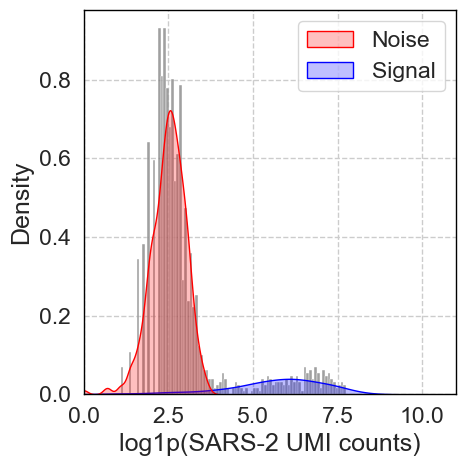

In [15]:
sns.set(rc = {'figure.figsize':(5,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',
    'axes.spines.right': True,'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette='Set2')


sns.set_style("whitegrid", {"ytick.major.size": 0.1, "ytick.minor.size": 0.05,
    'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True,'axes.spines.top': True })

def convert_params(mle_mix_params):
    '''Convert mixed distribution parameters to be n and p for use with Scipy nbinom'''
    n_signal = mle_mix_params[0]
    p_signal = 1/(1 + mle_mix_params[1])
    n_noise = mle_mix_params[2]
    p_noise= 1/(1 + mle_mix_params[3])
    w=mle_mix_params[4]

    return n_signal, p_signal, n_noise, p_noise, w

n_signal, p_signal, n_noise, p_noise, w = convert_params(nBinom_mixture.x)

samples = st.nbinom.rvs(n_noise, p_noise, size= int(0.866*len(x_signal)))
samples2 = st.nbinom.rvs(n_signal, p_signal, size=int(0.134*len(x_signal)))

pdf = pd.DataFrame([samples,samples2]).T
pdf.columns = ['Noise', 'Signal']
pdf = np.log1p(pdf)

sns.histplot(np.log1p(x_signal), kde=False,stat="density", color='grey', bins=85, label='Real UMIs') #, label='Real UMIs') #,ax = axes[0])
sns.kdeplot(data = pdf, fill=True, common_norm=True, palette=['red','blue'])

plt.xlim(0,11)
plt.xlabel('log1p(SARS-2 UMI counts)')
plt.tight_layout()

if save:
    plt.savefig(fig_output + 'fig4c.svg')

### Fig. 5: comparing output probabilities to LSS and in vitro validation

In [16]:
def calculate_component_probabilities(x_signal, umi, mle_params):

    probdf = pd.DataFrame(x_signal).copy()
    n_signal, p_signal, n_noise, p_noise, weight = convert_params(mle_params)

    probdf['pmf'] = (st.nbinom.pmf(probdf[umi], n_signal, p_signal))
    probdf['pmf_noise'] = (st.nbinom.pmf(probdf[umi], n_noise, p_noise))

    probdf['pmf'] = (st.nbinom.pmf(probdf[umi], n_signal, p_signal))
    probdf['pmf_noise'] = (st.nbinom.pmf(probdf[umi], n_noise, p_noise))

    pxa = (weight)*(probdf['pmf'])
    pxb = (1-weight)*(probdf['pmf_noise'])
    Px = pxa + pxb
    Pa = pxa/Px
    Pb = pxb/Px
    probdf['probsA'] = Pa
    probdf['probsB'] = Pb

    if st.nbinom.median(n_signal, p_signal) < st.nbinom.median(n_noise, p_noise):
        probdf['probsB'] = Pa
        probdf['probsA'] = Pb
    return probdf

In [17]:
prob_df = calculate_component_probabilities(x_signal, 'SARS-2', nBinom_mixture.x)

In [18]:
prob_df.head()

,SARS-2,pmf,pmf_noise,probsA,probsB
BARCODE,,,,,
AAACCTGAGAGGTAGA,11,0.002430,0.067711,0.005538,0.994462
AAACCTGAGATCACGG,8,0.002578,0.063034,0.006306,0.993694
AAACCTGCAAAGCGGT,4,0.002911,0.028350,0.015682,0.984318
AAACCTGCATTCACTT,10,0.002474,0.068341,0.005586,0.994414
AAACCTGGTCGAGATG,13,0.002354,0.061554,0.005899,0.994101


Fig. 5a

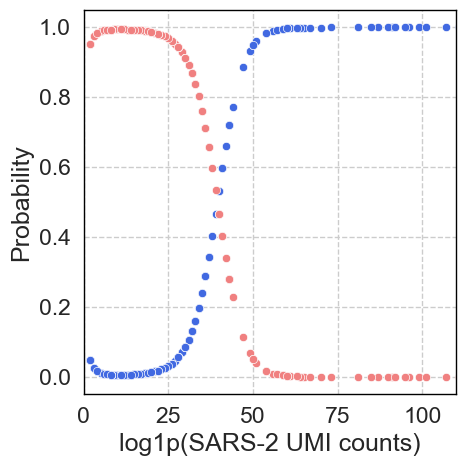

In [30]:
# sns.scatterplot(x=(x_signal[x_signal < 100]), y=probsB, label='Signal', color='lightcoral')
# sns.scatterplot(x=(x_signal[x_signal < 100]), y=probsA, label='Noise', color='slateblue')


sns.scatterplot(x=x_signal, y=prob_df['probsA'], color='royalblue') #label='Signal',
sns.scatterplot(x=(x_signal), y=prob_df['probsB'], color='lightcoral') # label='Noise',

plt.xlim(0,110)
plt.ylabel('Probability')
plt.xlabel('log1p(SARS-2 UMI counts)')

plt.tight_layout()

if save:
    plt.savefig(fig_output + 'fig5a.svg')

Fig. 5b

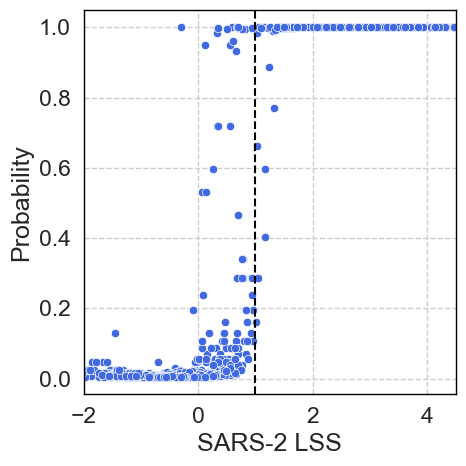

In [20]:
sns.set(rc = {'figure.figsize':(5,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',
    'axes.spines.right': True,'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette='Set2')
    
sns.set_style("whitegrid", {"ytick.major.size": 0.1, "ytick.minor.size": 0.05,
    'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True,'axes.spines.top': True })

sns.scatterplot(x=(donor_dfs[donor]['SARS-2.LSS']), y=prob_df['probsA'],  color='royalblue')
# sns.scatterplot(x=(lss_scores), y=probsA, label='Noise', color='slateblue')

plt.xlim(-2,4.5)
plt.ylabel('Probability')
plt.xlabel('SARS-2 LSS')
plt.axvline(x=1, ls='--', color='black')

plt.tight_layout()

if save:
    plt.savefig(fig_output + 'fig5b.svg')

Fig. 5c

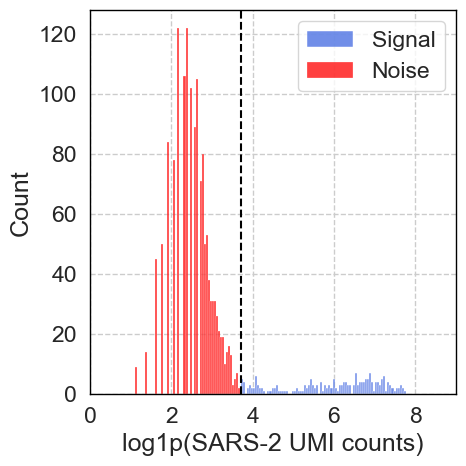

In [21]:
sns.set(rc = {'figure.figsize':(5,5), 'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor': 'black',
    'axes.spines.right': True,'axes.spines.top': True, 'axes.linewidth': 1, 'axes.grid':True}, font_scale=1.5, palette='Set2')
    
sns.set_style("whitegrid", {"ytick.major.size": 0.1, "ytick.minor.size": 0.05,
    'grid.linestyle': '--', 'axes.edgecolor': 'black', 'axes.spines.right': True,'axes.spines.top': True })

signal_counts = np.log1p(prob_df[prob_df['probsA'] > 0.5]['SARS-2'])
noise_counts = np.log1p(prob_df[prob_df['probsA'] <= 0.5]['SARS-2'])

sns.histplot(signal_counts, color='royalblue', binwidth=0.05, label = 'Signal') 
sns.histplot(noise_counts, color='red', binwidth=0.05, label = 'Noise') 

plt.axvline(min(signal_counts), 0,120, color='black', linestyle='--')
plt.legend()
plt.xlim(0,9)
plt.xlabel('log1p(SARS-2 UMI counts)')
plt.tight_layout()
if save:
    plt.savefig(fig_output + 'fig5c.svg')

### Comparing Ps to ELISA data

In [27]:
elisa_df = pd.read_csv('./data/validation/elisa_val_data_MM.csv', index_col=0)

In [28]:
sars2_elisa_df = elisa_df[~elisa_df['SARS_2'].isna()]

sars2_values = {}
for donor in donor_dfs:
    lseq_df = donor_dfs[donor].copy()
    elisa_overlap = (sars2_elisa_df.loc[np.intersect1d(sars2_elisa_df.index, lseq_df.index)])
    elisa_overlap['UMIs'] = lseq_df.loc[np.intersect1d(sars2_elisa_df.index, lseq_df.index)]['SARS-2']
    
    num_cells = elisa_overlap.shape[0]
    if num_cells > 0:
        sars2_values[donor] = elisa_overlap[['SARS_2', 'SARS_2.LSS', 'UMIs']]

Table used for Fig. 5d/e
* tables across donors combined and plotted as heatmap in Excel

In [29]:
comparison_df = pd.concat(sars2_values)
comparison_df.index = comparison_df.index.get_level_values(1)
comparison_df['Prob'] = prob_df['probsA'].loc[np.intersect1d(comparison_df.index, prob_df.index)]
comparison_df.dropna(inplace=True)
comparison_df.columns = ['ELISA', 'SARS-2.LSS', 'UMIs', 'Ps']
comparison_df

,ELISA,SARS-2.LSS,UMIs,Ps
Barcode,,,,
ACGCCAGCAGGGAGAG,0.078,1.419758,87,1.000000
CGAGCACCAAGGTTTC,0.089,1.143706,81,0.999996
CGGGTCACACCACGTG,1.513,1.649414,101,1.000000
GCTTCCAAGTCCTCCT,0.058,-2.244659,9,0.005821
GGCAATTTCCATGAGT,0.149,4.580647,958,1.000000
